In [1]:
## Best CNN Model 

In [2]:
## Data augmentation 방법 추가!!

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import ndimage


In [50]:
## 1. set hyper parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

# set checkpoint saving directory
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'mnist_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok = True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

In [9]:
## 2. Data augmentataion - rotate & shift
def data_augmentation(images, labels):
    aug_images = []
    aug_labels = []    
    
    for x, y in zip(images, labels):        
        aug_images.append(x)
        aug_labels.append(y)        
        
        bg_value = np.median(x)
        
        for _ in range(4):
            angle = np.random.randint(-15, 15, 1)            
            rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=bg_value)
            
            shift = np.random.randint(-2, 2, 2)
            shift_img = ndimage.shift(rot_img, shift, cval=bg_value)
            # -2,2 사이 숫자 2개 뽑아서 하나는 세로방향, 하나는 가로방향만큼 shift       
            
            aug_images.append(shift_img)
            aug_labels.append(y)
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels)
    return aug_images, aug_labels

In [10]:
# 3. make a data pipelining

mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images, train_labels = data_augmentation(train_images, train_labels)

train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis = -1)  # for 4D shape
test_images = np.expand_dims(test_images, axis = -1)  # for 4D shape

#one hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size = 500000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)

# shuffle : 고정된 buffer_size만큼 epoch 마다 이미지를 섞어서 오버피팅이 줄도록 도와줌

In [22]:
# aa = train_images[0]

In [24]:
# bb = aa.reshape([28,28])

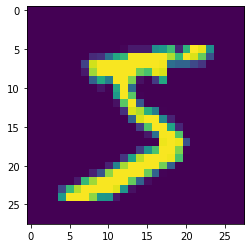

In [27]:
# plt.imshow(bb)
# plt.show()

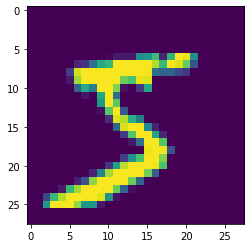

In [28]:
# shift = np.random.randint(-2, 2, 2)
# bg = np.median(bb)
# cc = ndimage.shift(bb, shift, cval=bg)
# plt.imshow(cc)
# plt.show()

In [31]:
print(train_images.shape, train_labels.shape)

(300000, 28, 28, 1) (300000, 10)


In [41]:
## 4. build a neural network model
class ConvBNRelu(tf.keras.Model) :
  def __init__(self, filters, kernel_size = 3, strides = 1, padding = 'SAME') :
    super(ConvBNRelu, self).__init__()
    self.conv = keras.layers.Conv2D(filters = filters, kernel_size = kernel_size,
                                    strides = strides, padding = padding, 
                                    kernel_initializer = 'glorot_normal')
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, inputs, training=False) :
    layer = self.conv(inputs)
    layer = self.batchnorm(layer)
    layer = tf.nn.relu(layer)
    return layer

In [42]:
class DenseBNRelu(tf.keras.Model) :
  def __init__(self, units) :
    super(DenseBNRelu, self).__init__()
    self.dense = keras.layers.Dense(units = units,
                                    kernel_initializer = 'glorot_normal')
    self.batchnorm = tf.keras.layers.BatchNormalization()

  def call(self, inputs, training=False) :
    layer = self.dense(inputs)
    layer = self.batchnorm(layer)
    layer = tf.nn.relu(layer)
    return layer

In [43]:
class MNISTModel(tf.keras.Model):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv1 = ConvBNRelu(filters=32, kernel_size=[3, 3], padding='SAME')        
        self.pool1 = keras.layers.MaxPool2D(padding='SAME')
        self.conv2 = ConvBNRelu(filters=64, kernel_size=[3, 3], padding='SAME')
        self.pool2 = keras.layers.MaxPool2D(padding='SAME')
        self.conv3 = ConvBNRelu(filters=128, kernel_size=[3, 3], padding='SAME')
        self.pool3 = keras.layers.MaxPool2D(padding='SAME')
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = DenseBNRelu(units=256)
        self.drop4 = keras.layers.Dropout(rate=0.4)
        self.dense5 = keras.layers.Dense(units=10, kernel_initializer='glorot_normal')
    def call(self, inputs, training=False):
        net = self.conv1(inputs)        
        net = self.pool1(net)
        net = self.conv2(net)
        net = self.pool2(net)
        net = self.conv3(net)
        net = self.pool3(net)
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.drop4(net)
        net = self.dense5(net)
        return net

In [44]:
models = []
num_models = 5
for m in range(num_models) :
  models.append(MNISTModel())

In [45]:
# 4,5 define a loss function & calculate a gradient 
def loss_fn(model, images, labels) :
  logits = model(images, training = True) # Dropout 적용됨
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
  return loss


def grad(model, image, labels) :
  with tf.GradientTape() as tape :
    loss = loss_fn(model, images, labels) 
  return tape.gradient(loss, model.variables) #loss 를 이 모델에 있는 모든 parameter에 대해서 미분한 값을 구해주세요

In [51]:
########## 변화가 있는 부분  
# 6. select an optimizer - Adam.. etc
# 7. define a metric for model's performance - accuracy etc
# 8. (optional) make a checkpoint for saving

def evaluate(models, images, labels):
    predictions = np.zeros_like(labels)
    for model in models:
        logits = model(images, training=False)
        predictions += logits
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

# learning rate decay
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
                                                          train_images.shape[0]/batch_size*num_models*5,
                                                          0.5, staircase=True)
# 전체 train image 개수 / batch_size*num_models*5  : 5 epoch 의미   / 앙상블 모델이므로 전체 트레인 데이터 수 / batch_size*모델 수 를 해야 1 epoch
# 5 epoch 후 learning rate * 0.5 
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_decay)

In [52]:
checkpoints = []
for m in range(num_models):
    checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

In [ ]:
# 변경 O
# 9.  train an validate a neural network model

for epoch in range(training_epochs) :
  avg_loss = 0
  avg_train_acc = 0
  avg_test_acc = 0
  train_step = 0
  test_step = 0

  for images, labels in train_dataset :
    for model in models :
      grads = grad(model, images, labels)
      optimizer.apply_gradients(zip(grads, model.variables))
      loss = loss_fn(model, images, labels)
      avg_loss += loss/num_models   # 1/3(a+b) = 1/3*a + 1/3*b
    acc = evaluate(models, images, labels)
    avg_train_acc = avg_train_acc + acc
    train_step += 1
  
  avg_loss = avg_loss / train_step
  avg_train_acc = avg_train_acc / train_step
  
  for images, labels in test_dataset:
    acc = evaluate(models, images, labels)        
    avg_test_acc += acc
    test_step += 1    
  avg_test_acc = avg_test_acc / test_step   

  print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
        'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
        'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
  for idx, checkpoint in enumerate(checkpoints) :
    checkpoint.save(file_prefix=checkpoint_prefix+'-{}'.format(idx)) # epoch 한번 끝날때마다 모델 저장

print('Learning Finished!')